In [1]:
import os
import geopandas as gpd
import requests
import pandas as pd
import folium
import matplotlib.pyplot as plt
import itertools
from folium.plugins import Fullscreen

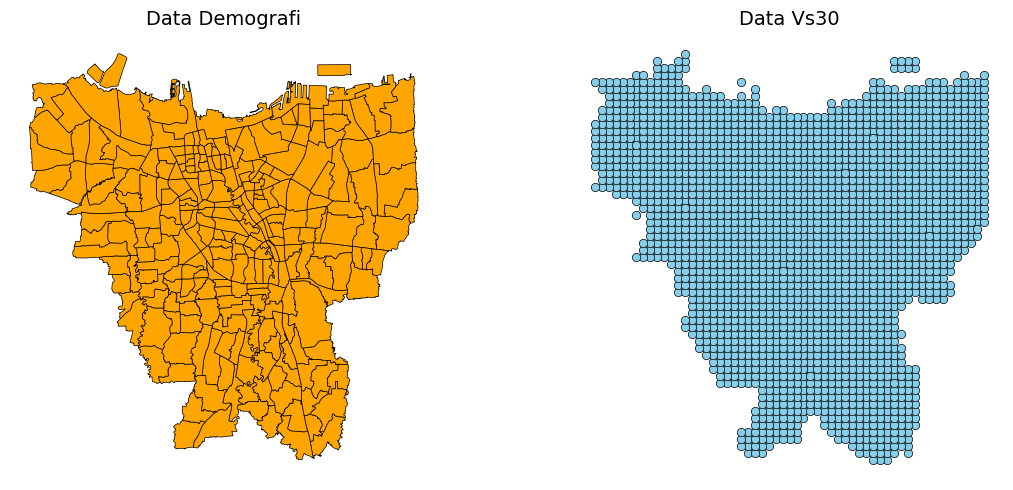

In [ ]:
# ------------------------------------------------------------------
# 1. Daftar URL API
# ------------------------------------------------------------------
urls = {
    "Demografi": "https://geoserver.mapid.io/layers_new/get_layer?api_key=b79dbb1727c346dd953307ca0423d7e0&layer_id=69005d82c8804625c689f408&project_id=68ff9caac8804625c64612ff&limit=10000",
    "Vs30":     "https://geoserver.mapid.io/layers_new/get_layer?api_key=b79dbb1727c346dd953307ca0423d7e0&layer_id=68ffb263c8804625c649cf24&project_id=68ff9caac8804625c64612ff&limit=10000"
}

# ------------------------------------------------------------------
# 2. Fungsi pengambilan data
# ------------------------------------------------------------------
def get_data(url: str, layer_name: str) -> gpd.GeoDataFrame:
    resp = requests.get(url, timeout=30)
    if resp.status_code != 200:
        raise RuntimeError(
            f"Failed Get Data from {url} - Status Code: {resp.status_code}"
        )
    data = resp.json()
    if "features" not in data:
        raise RuntimeError(f"API response missing 'features': {data}")

    gdf = gpd.GeoDataFrame.from_features(data["features"])
    gdf.set_geometry("geometry", inplace=True)   # aman walau sudah ada
    gdf.set_crs("EPSG:4326", inplace=True)
    return gdf

# ------------------------------------------------------------------
# 3. Ambil data masing‑masing layer
# ------------------------------------------------------------------
gdf_demografi = get_data(urls["Demografi"], "Demografi")
gdf_vs30     = get_data(urls["Vs30"], "Vs30")

# ------------------------------------------------------------------
# 4. Visualisasi
# ------------------------------------------------------------------
def visualize_data(gdfs: dict):
    n = len(gdfs)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5), squeeze=False)
    colors = itertools.cycle(["yellow", "orange", "lightgreen", "skyblue"])

    for ax, (name, gdf), color in zip(axes.flat, gdfs.items(), colors):
        gdf.plot(ax=ax, color=next(colors), edgecolor="black", linewidth=0.5)
        ax.set_title(name, fontsize=14)
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

visualize_data({
    "Data Demografi": gdf_demografi,
    "Data Vs30": gdf_vs30
})

In [3]:
import requests
import geopandas as gpd
import pandas as pd
import numpy as np

# ------------------------------------------------------------------
# 1. Daftar URL API
# ------------------------------------------------------------------
urls = {
    "Demografi": "https://geoserver.mapid.io/layers_new/get_layer?api_key=b79dbb1727c346dd953307ca0423d7e0&layer_id=69005d82c8804625c689f408&project_id=68ff9caac8804625c64612ff&limit=10000",
    "Vs30":     "https://geoserver.mapid.io/layers_new/get_layer?api_key=b79dbb1727c346dd953307ca0423d7e0&layer_id=68ffb263c8804625c649cf24&project_id=68ff9caac8804625c64612ff&limit=10000"
}

# ------------------------------------------------------------------
# 2. Fungsi pengambilan data dari API
# ------------------------------------------------------------------
def get_data(url: str, layer_name: str) -> gpd.GeoDataFrame:
    print(f"\n🔍 Mengambil data dari {layer_name}...")
    try:
        resp = requests.get(url, timeout=30)
        if resp.status_code != 200:
            raise RuntimeError(f"Failed to fetch {layer_name}: Status {resp.status_code} - {resp.text}")
        
        data = resp.json()
        if "features" not in data:
            raise ValueError(f"API response tidak berisi 'features': {data}")
        
        gdf = gpd.GeoDataFrame.from_features(data["features"])
        gdf.set_geometry("geometry", inplace=True)
        gdf.set_crs("EPSG:4326", inplace=True)
        
        print(f"✅ Sukses: {len(gdf)} fitur ditemukan di layer {layer_name}")
        return gdf
    except Exception as e:
        raise RuntimeError(f"Error saat memproses {layer_name}: {str(e)}")

# ------------------------------------------------------------------
# 3. Ambil data dari API (langsung, tanpa menyimpan file)
# ------------------------------------------------------------------
print("🚀 Memulai proses penggabungan data...")

gdf_demografi = get_data(urls["Demografi"], "Demografi")
gdf_vs30 = get_data(urls["Vs30"], "Vs30")

# ------------------------------------------------------------------
# 4. Cek apakah kolom OBJECTID ada di kedua data
# ------------------------------------------------------------------
print("\n🔍 Memeriksa ketersediaan kolom OBJECTID...")

if 'OBJECTID' in gdf_demografi.columns and 'OBJECTID' in gdf_vs30.columns:
    print("✅ Kolom OBJECTID ditemukan di kedua layer. Melakukan join berdasarkan OBJECTID.")

    # Group Vs30 per OBJECTID: ambil rata-rata nilai vs30
    vs30_avg = gdf_vs30.groupby('OBJECTID')['vs30'].mean().reset_index()
    vs30_avg.rename(columns={'vs30': 'vs30_avg'}, inplace=True)

    # Lakukan merge ke data demografi
    merged = gdf_demografi.merge(vs30_avg, on='OBJECTID', how='left')

    # ✅ Ambil data kepadatan penduduk dari kolom KEPADATAN PENDUDUK 2024
    # Pastikan kolom ada dan konversi ke numerik
    if 'KEPADATAN PENDUDUK 2024' in merged.columns:
        # Hilangkan koma dan ruang, lalu konversi ke float
        merged['KEPADATAN PENDUDUK 2024'] = merged['KEPADATAN PENDUDUK 2024'].astype(str).str.replace(',', '', regex=False)
        merged['KEPADATAN PENDUDUK 2024'] = pd.to_numeric(merged['KEPADATAN PENDUDUK 2024'], errors='coerce')
        
        # Gunakan kolom ini sebagai `kepadatan`
        merged['kepadatan'] = merged['KEPADATAN PENDUDUK 2024']
        print("✅ Kolom kepadatan berhasil diambil dari 'KEPADATAN PENDUDUK 2024' dan dikonversi ke angka.")
    else:
        print(f"⚠️ Kolom 'KEPADATAN PENDUDUK 2024' tidak ditemukan. Cek struktur data.")
        merged['kepadatan'] = None

    # Cek hasil join
    match_rate = (merged['vs30_avg'].notna().sum() / len(merged)) * 100
    print(f"✅ Join berhasil. Tingkat kesesuaian: {match_rate:.1f}%")

else:
    # Jika OBJECTID tidak tersedia, gunakan spatial join
    print("⚠️ OBJECTID tidak tersedia di salah satu layer. Melakukan spatial join (contains).")
    
    merged_spatial = gpd.sjoin(gdf_demografi, gdf_vs30[['geometry', 'vs30']], how='left', predicate='contains')
    
    if merged_spatial.empty:
        print("❌ Spatial join gagal — tidak ada data yang cocok.")
        merged = gdf_demografi.copy()
        merged['vs30_avg'] = None
        merged['kepadatan'] = None
    else:
        vs30_avg = merged_spatial.groupby(merged_spatial.index)['vs30'].mean().reset_index(name='vs30_avg')
        merged = gdf_demografi.copy()
        merged = merged.merge(vs30_avg, left_index=True, right_on='index', how='left')
        merged.drop(columns=['index'], inplace=True)

        # ✅ Ambil kepadatan dari KEPADATAN PENDUDUK 2024
        if 'KEPADATAN PENDUDUK 2024' in merged.columns:
            merged['KEPADATAN PENDUDUK 2024'] = merged['KEPADATAN PENDUDUK 2024'].astype(str).str.replace(',', '', regex=False)
            merged['KEPADATAN PENDUDUK 2024'] = pd.to_numeric(merged['KEPADATAN PENDUDUK 2024'], errors='coerce')
            merged['kepadatan'] = merged['KEPADATAN PENDUDUK 2024']
            print("✅ Kolom kepadatan dari 'KEPADATAN PENDUDUK 2024' berhasil diproses.")
        else:
            merged['kepadatan'] = None
            print("⚠️ Kolom 'KEPADATAN PENDUDUK 2024' tidak ditemukan saat join.")

        print("✅ Spatial join berhasil. Rata-rata Vs30 dihitung per wilayah.")

# ------------------------------------------------------------------
# 5. Simpan hasil akhir
# ------------------------------------------------------------------
output_file = 'combined_demografi_vs30.geojson'
merged.to_file(output_file, driver='GeoJSON')
print(f"💾 File berhasil disimpan: {output_file} (di direktori kerja Anda)")

# ------------------------------------------------------------------
# 6. Tampilkan ringkasan hasil
# ------------------------------------------------------------------
print(f"\n📊 Ringkasan Final:")
print(f"   Total data: {len(merged)} wilayah")
print(f"   Rentang Vs30: {merged['vs30_avg'].min():.2f} - {merged['vs30_avg'].max():.2f}")
print(f"   Rata-rata Vs30: {merged['vs30_avg'].mean():.2f}")
print(f"   Rata-rata kepadatan penduduk: {merged['kepadatan'].mean():.2f} (dari KEPADATAN PENDUDUK 2024)")

print("\n✅ Proses selesai! File GeoJSON sudah diperbarui dengan data kepadatan yang benar dari kolom 'KEPADATAN PENDUDUK 2024'.")


🚀 Memulai proses penggabungan data...

🔍 Mengambil data dari Demografi...
✅ Sukses: 261 fitur ditemukan di layer Demografi

🔍 Mengambil data dari Vs30...
✅ Sukses: 2124 fitur ditemukan di layer Vs30

🔍 Memeriksa ketersediaan kolom OBJECTID...
⚠️ OBJECTID tidak tersedia di salah satu layer. Melakukan spatial join (contains).
✅ Kolom kepadatan dari 'KEPADATAN PENDUDUK 2024' berhasil diproses.
✅ Spatial join berhasil. Rata-rata Vs30 dihitung per wilayah.
💾 File berhasil disimpan: combined_demografi_vs30.geojson (di direktori kerja Anda)

📊 Ringkasan Final:
   Total data: 261 wilayah
   Rentang Vs30: 119.27 - 339.22
   Rata-rata Vs30: 226.15
   Rata-rata kepadatan penduduk: 23478.10 (dari KEPADATAN PENDUDUK 2024)

✅ Proses selesai! File GeoJSON sudah diperbarui dengan data kepadatan yang benar dari kolom 'KEPADATAN PENDUDUK 2024'.
